# Topic Modeling on a Small Scientific Corpus

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Clustering_USGS"

/content/drive/MyDrive/Clustering_USGS


In [3]:
%%capture
!pip install umap-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import gensim
from gensim import corpora
from gensim import models

import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
df = pd.read_csv('abstracts.csv')
dataset = df.copy()
dataset = dataset[['Title']]

In [5]:
df_test = pd.read_csv('abstracts_test.csv')
df_test = df_test[['Title', 'Text']]
df_test = df_test.dropna()

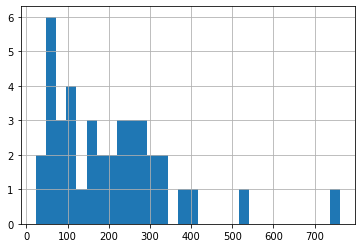

In [6]:
def word_count(text):
    return len(str(text).strip().split(" "))
    
temp_df = df.copy()
temp_df['word_count'] = temp_df['Text'].apply(word_count)
pd.Series(temp_df.word_count.values).hist(bins = 30)

### Preprocess Data for BoW Models

In [7]:
nltk.download('stopwords')
sw = stopwords.words('english')
sw = set(sw)

def preprocess_data(documents):
  tokenizer = RegexpTokenizer(r'\w+')
  stemmer = SnowballStemmer("english")
  texts = []
  for i in documents:
        lower_text = i.lower()
        # tokenize
        tokens = tokenizer.tokenize(lower_text)
        # remove stopwords
        stopped_tokens = [i for i in tokens if not i in sw]
        # stem words
        stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
        # append list
        texts.append(stemmed_tokens)
  return texts


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
document_list = df.Text.values
tokens = preprocess_data(document_list)

In [9]:
test_document_list = df_test.Text.values
test_tokens = preprocess_data(test_document_list)

In [10]:
dictionary = corpora.Dictionary(tokens)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in tokens]

In [11]:
test_BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in test_tokens]

In [12]:
# # Human-readable dictionary
# id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
# print(id_words)

In [13]:
tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

In [14]:
test_corpus_tfidf = tfidf[test_BoW_corpus]

In [15]:
# # View td-idf
# for doc in tfidf[BoW_corpus]:
#    print([[dictionary[id], round(freq, 2)] for id, freq in doc])

### Preprocess Text for BERT-type Embeddings

In [16]:
document_list = df.Text.values

Yep. That's it!

## Number of Clusters
I could get rid of this analysis or show how ineffective it is in determining the number of clusters

In [17]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = models.LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [18]:
def plot_graph(dictionary, doc_term_matrix, doc_clean, start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


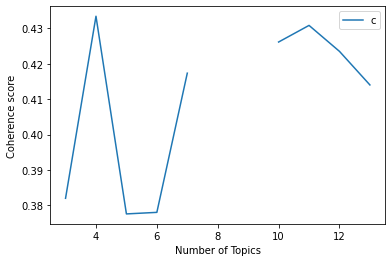

In [19]:
start,stop,step = 2,14,1
plot_graph(dictionary, corpus_tfidf, tokens, start, stop, step)

In [20]:
no_clusters = 9 #Not effective for selecting number of clusers. Varies with each run: 4, 7, 9, 11, etc.

## Latent Semantic Analysis (LSA/LSI)

In [21]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=no_clusters)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]
test_corpus_lsi = lsi_model[test_corpus_tfidf]

In [22]:
# lsi_model.print_topics(9)

In [23]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: abs(x[1]), reverse = True) 
    return tup 

In [24]:
cluster_lsa = []
for i in range(len(corpus_tfidf)):
  x = lsi_model[corpus_tfidf[i]]
  x = Sort_Tuple(x)
  cluster_lsa.append(x[0][0])
dataset['LSA_Topic'] = cluster_lsa
dataset["LSA_Topic"] = pd.to_numeric(dataset["LSA_Topic"])

In [25]:
# dic1 = {0: 'transport_structur_flow_ground',
#     1: 'feq_structur_unsteadi_stream',
#     2: 'water_balance_transport_watersh',
#     3: 'transport_rainfall_veget_balance',
#     4: 'hydraul_modflow_veget',
#     5: 'wave_reef_ocean_flood',
#     6: 'veget_month_tool_reservoir',
#     7: 'watersh_cblcm_land_contam',
#     8: 'reservoir_veget_balanc'}
# dataset.replace({"LSA_Topic": dic1},inplace=True)

We transform the training corpus here with the LSA model; however, once the transformation model has been initialized it can be used on any corpus provided it comes from the same vector space. 

In [26]:
# for doc, as_text in zip(corpus_lsi, document_list):
#     print(doc, as_text)

## Latent Dirichlet Allocation (LDA)

In [27]:
lda_model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=no_clusters, iterations=100)

In [28]:
corpus_lda = lsi_model[corpus_tfidf]

In [29]:
# lda_model.print_topics(9)

In [30]:
cluster_lda = []
for i in range(len(corpus_tfidf)):
  x = lda_model[corpus_tfidf[i]]
  x = Sort_Tuple(x)
  cluster_lda.append(x[0][0])
dataset['LDA_Topic'] = cluster_lda

In [31]:
# dic2 = {0: 'structur_flow_record_conduct',
#       1: 'reef_migrat_flodd_dispers',
#       2: 'subduct_erupt_ash_feq_volcan',
#       3: 'subduc_structur_map_watersh',
#       4: 'cblcm_veget_land_submers',
#       5: 'scoops3d_dem_site_goal_statement',
#       6: 'reservoir_veget_keyword_modul',
#       7: 'threshold_rainfal_speci_precip',
#       8: 'psd_perman_channel_network_streamflow'}
# dataset.replace({"LDA_Topic": dic2}, inplace=True)

## HDBSCAN 

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=1000,
                                   stop_words='english')
tfidf_vec = tfidf_vectorizer.fit_transform(document_list)
# tfidf_tokens = tfidfvectorizer.get_feature_names()

In [33]:
%%capture
!pip install hdbscan
import hdbscan

In [34]:
hdb_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom',prediction_data=False) #min_samples=2, 
hdp_labels = hdb_model.fit_predict(tfidf_vec)
dataset['HDBSCAN_Topic'] = hdp_labels

In [35]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(hdp_labels)) - (1 if -1 in hdp_labels else 0)
n_noise_ = list(hdp_labels).count(-1)

## Top2Vec
Deep HDBSCAN: Create jointly embedded document and word vectors using BERT Sentence Transformer. Create lower dimensional embedding of document vectors using UMAP. Find dense areas of documents using HDBSCAN.  For each dense area calculate the centroid of document vectors in original dimension, this is the topic vector.  Find n-closest word vectors to the resulting topic vector. <br><br>
*Error: need at least one array to concatenate. The model is putting everyhing into one topic and crashing*<br>

In [36]:
# %%capture
# !pip install torch sentence_transformers
# !pip install top2vec[sentence_transformers]
# from top2vec import Top2Vec

In [37]:
# top2vec_model = Top2Vec(document_list, embedding_model='distiluse-base-multilingual-cased', use_embedding_model_tokenizer = True)

## BERTopic

In [38]:
%%capture
!pip install bertopic[all]
from bertopic import BERTopic
import umap
from umap import UMAP
#Note that if this gives an error on the first run, just run it again and it works.

In [39]:
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True) #leaf_size=10, cluster_selection_epsilon=0.5, min_samples=2, 

topic_model = BERTopic(umap_model = umap_model, hdbscan_model=hdbscan_model, embedding_model="paraphrase-distilroberta-base-v1", 
                       min_topic_size=2, calculate_probabilities= True, language="english", n_gram_range=(1, 3)) #n_gram_range=(1, 3)
# topic_model = BERTopic(hdbscan_model=hdbscan_model, embedding_model="bert-large-nli-stsb-mean-tokens", min_topic_size=2)
# topic_model = BERTopic(hdbscan_model=hdbscan_model, embedding_model="stsb-mpnet-base-v2", min_topic_size=2)

topics, probs  = topic_model.fit_transform(document_list)

In [40]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,9,-1_program_scoops3d_3d_map
1,4,9,4_model_transport_can be_can
2,1,8,1_species_wave_fish_climate
3,5,5,5_software_vs2drti_users_transport
4,3,4,3_flow_aquifer_hydraulic_interface
5,0,3,0_modflow_flow_lpf_upw
6,2,2,2_psd_nurp_the cblcm_cblcm


In [41]:
topic_model.get_topic(3)

[('flow', 0.02027097992759909),
 ('aquifer', 0.016627425456626314),
 ('hydraulic', 0.01630561388379467),
 ('interface', 0.015757333295100266),
 ('subduction', 0.01492632364838563),
 ('pumping', 0.01492632364838563),
 ('simulated', 0.013348119685362075),
 ('saltwater', 0.012347513474836388),
 ('hydraulic conductivity', 0.011941058918708503),
 ('conductivity', 0.011941058918708503)]

In [76]:
topic_model.get_topic(0)

[('modflow', 0.028229997083983698),
 ('flow', 0.02653090706232892),
 ('lpf', 0.01853307099542285),
 ('upw', 0.016279233178996204),
 ('modflow nwt', 0.016279233178996204),
 ('upw package', 0.016279233178996204),
 ('lpf package', 0.013954110996958213),
 ('the lpf package', 0.013954110996958213),
 ('the upw package', 0.013954110996958213),
 ('the lpf', 0.013954110996958213)]

In [43]:
topic_model.find_topics("pollution")

([3, 0, 1, 4, 5],
 [0.5484616581333599,
  0.45279863810130366,
  0.441469870519045,
  0.40573904098302205,
  0.40026328891270446])

In [44]:
topic_model.visualize_topics()

In [45]:
topic_model.visualize_distribution(probs[0])

In [46]:
topic_model.visualize_distribution(probs[1])

In [47]:
topic_model.visualize_distribution(probs[2])

In [48]:
bertopic_labels = np.argmax(probs, axis=1)
dataset['BERTopic_Topic'] = bertopic_labels

In [50]:
topic_model.get_params()

{'calculate_probabilities': True,
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7f3b4d788cd0>,
 'hdbscan_model': HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
         approx_min_span_tree=True, cluster_selection_epsilon=0.0,
         cluster_selection_method='eom', core_dist_n_jobs=4,
         gen_min_span_tree=False, leaf_size=40,
         match_reference_implementation=False, memory=Memory(location=None),
         metric='euclidean', min_cluster_size=2, min_samples=None, p=None,
         prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 2,
 'n_gram_range': (1, 3),
 'nr_topics': None,
 'top_n_words': 10,
 'umap_model': UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
      dens_var_shift=0.1, densmap=False, disconnection_distance=None,
      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
      local_connectivity=1.0, low_memory=True, 

## Evaluation

### TRAINING SET TOPIC RESULTS

#### LSA

##### Coherence Score -11.5

In [51]:
cm = models.CoherenceModel(model= lsi_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
lsa_score = cm.get_coherence()
lsa_score

-11.471560810697863

##### Silhouette Score 0.13

In [52]:
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
score = metrics.silhouette_score(X, cluster_lsa)
score

0.12625283051867323

##### Titles Grouped by Topic

In [53]:
df_LSA = dataset.groupby('LSA_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_LSA)):
  print('LSA topic:', df_LSA.LSA_Topic[i])
  for j in df_LSA.Title[i]:
    print(j)
  print(' ')
  

LSA topic: 0
TRIGRS—A Fortran Program for Transient
Rainfall Infiltration and Grid-Based Regional
Slope-Stability Analysis, Version 2.0
THE COMPUTER MODEL SHARP, A QUASI-THREE-DIMENSIONAL FINITE-DIFFERENCE
MODEL TO SIMULATE FRESHWATER AND SALTWATER FLOW IN LAYERED COASTAL
AQUIFER SYSTEMS
FaSTMECH - Flow and Sediment Transport with Morphological Evolution of Channels
VS2DRTI - A Graphical Software Package for Simulating Water Flow, Heat Transport, and Reactive Solute Transport
USER'S MANUAL FOR WATEQ4F, WITH REVISED THERMODYNAMIC DATA
BASE AND TEST CASES FOR CALCULATING SPECIATION OF MAJOR,
TRACE, AND REDOX ELEMENTS IN NATURAL WATERS
VFLUX: Vertical Fluid Heat Transfer Solver (VFlu[H]X Solver)
HYDROTHERM - A computer code for simulation of two-phase ground-water flow and heat transport
USERS MANUAL FOR A BRANCHED
LAGRANGIAN TRANSPORT MODEL
Ash3d: A finite‐volume, conservative numerical model for ash transport and tephra deposition
Description of input and examples for PHREEQC version 3:

Can't use pyLDAvis on LSA, no inference

#### LDA

##### Coherence Score -12.2

In [54]:
cm = models.CoherenceModel(model= lda_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
lda_score = cm.get_coherence()
lda_score

-12.779054430877968

##### Silhouette Score -0.13

In [55]:
LDA_score = metrics.silhouette_score(X, cluster_lda)
LDA_score

-0.12989180767457578

##### Titles Grouped by Topic

In [56]:
df_LDA = dataset.groupby('LDA_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_LDA)):
  print('LDA topic:', df_LDA.LDA_Topic[i])
  for j in df_LDA.Title[i]:
    print(j)
  print(' ')

LDA topic: 0
THRESH—Software for Tracking Rainfall Thresholds for Landslide and Debris-Flow Occurrence, User Manual
A Monthly Water-Balance Model Driven By a Graphical User
Interface
Submersed Aquatic Vegetation Modeling Output Online
Probability of Streamflow Permanence Model (PROSPER): A spatially continuous model of annual streamflow permanence throughout the Pacific Northwest
 
LDA topic: 1
SLAMMER—Seismic LAndslide Movement Modeled using Earthquake Records
FishVis, A regional decision support tool for identifying vulnerabilities of riverine habitat and fishes to climate change in the Great Lakes Region
One-Dimensional Transport with Equilibrium
Chemistry (OTEQ)—A Reactive Transport
Model for Streams and Rivers
FaSTMECH - Flow and Sediment Transport with Morphological Evolution of Channels
Delft3D - 3D modeling suite to investigate hydrodynamics, sediment transport and morphology and water quality for fluvial, estuarine and coastal environments
MODFLOW-NWT, A Newton Formulation for

##### pyLDAvis

In [77]:
%%capture
!pip install pyLDAvis==3.3.1
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [80]:
vis_data1 = gensimvis.prepare(lda_model, BoW_corpus, dictionary)
pyLDAvis.display(vis_data1)

#### **HDBSCAN**

##### Coherence Score - n/a

In [57]:
# cm = models.CoherenceModel(model= hdb_model, corpus = corpus_tfidf, texts=document_list, dictionary=dictionary, coherence='u_mass')
# lsa_score = cm.get_coherence()

# ValueError: This topic model is not currently supported. Supported topic models should implement the `get_topics` method.

##### Silhouette Score 0.05

In [58]:
HDB_score = metrics.silhouette_score(X, hdp_labels)
HDB_score

0.048756017504567394

##### Titles Grouped by Topic

In [59]:
df_HDB = dataset.groupby('HDBSCAN_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_HDB)):
  print('HDBSCAN topic:', df_HDB.HDBSCAN_Topic[i])
  for j in df_HDB.Title[i]:
    print(j)
  print(' ')

HDBSCAN topic: -1
The Effect of Particle Size Distribution on the Design of Urban Stormwater Control Measures
SLAMMER—Seismic LAndslide Movement Modeled using Earthquake Records
The SPARROW Surface Water-Quality Model: Theory, Application and User Documentation
Modeling Landscape Evapotranspiration by Integrating Land Surface Phenology and a Water Balance Algorithm
Benefits of the destinations, not costs of the journeys, shape partial migration patterns
FishVis, A regional decision support tool for identifying vulnerabilities of riverine habitat and fishes to climate change in the Great Lakes Region
Probability of Streamflow Permanence Model (PROSPER): A spatially continuous model of annual streamflow permanence throughout the Pacific Northwest
VS2DRTI - A Graphical Software Package for Simulating Water Flow, Heat Transport, and Reactive Solute Transport
USER'S MANUAL FOR WATEQ4F, WITH REVISED THERMODYNAMIC DATA
BASE AND TEST CASES FOR CALCULATING SPECIATION OF MAJOR,
TRACE, AND REDOX 

#### BERTopic

##### Coherence Score - n/a

In [60]:
# cm = models.CoherenceModel(model= topic_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
# lda_score = cm.get_coherence()
# lda_score

##### Silhouettte Score 0.06

In [61]:
BERT_score = metrics.silhouette_score(X, bertopic_labels)
BERT_score

0.024585183243424846

##### Titles Grouped by Topic

In [62]:
df_BERTopic = dataset.groupby('BERTopic_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_BERTopic)):
  print('HDBSCAN topic:', df_BERTopic.BERTopic_Topic[i])
  for j in df_BERTopic.Title[i]:
    print(j)
  print(' ')

HDBSCAN topic: 0
Modeling Landscape Evapotranspiration by Integrating Land Surface Phenology and a Water Balance Algorithm
FaSTMECH - Flow and Sediment Transport with Morphological Evolution of Channels
Delft3D - 3D modeling suite to investigate hydrodynamics, sediment transport and morphology and water quality for fluvial, estuarine and coastal environments
Update of the Graizer-Kalkan ground-motion prediction equations for shallow crustal continental earthquakes
MODFLOW-NWT, A Newton Formulation for MODFLOW-2005
 
HDBSCAN topic: 1
Massachusetts Reservoir Simulation Tool—User’s Manual
Benefits of the destinations, not costs of the journeys, shape partial migration patterns
FishVis, A regional decision support tool for identifying vulnerabilities of riverine habitat and fishes to climate change in the Great Lakes Region
Submersed Aquatic Vegetation Modeling Output Online
Probability of Streamflow Permanence Model (PROSPER): A spatially continuous model of annual streamflow permanence t

### TESTING SET TOPIC RESULTS

#### LSA

In [63]:
test_cluster_lsa = []
for i in range(len(test_corpus_tfidf)):
  x = lsi_model[test_corpus_tfidf[i]]
  x = Sort_Tuple(x)
  test_cluster_lsa.append(x[0][0])
df_test['LSA_Topic'] = test_cluster_lsa
df_test["LSA_Topic"] = pd.to_numeric(df_test["LSA_Topic"])

##### Coherence - NOT WORKING

In [64]:
# cm2 = models.CoherenceModel(model= lsi_model, corpus = test_BoW_corpus, texts=test_document_list, dictionary=dictionary, coherence='u_mass')
# lsa_score2 = cm2.get_coherence()
# lsa_score2

##### Silhouette Score 0.03

In [65]:
X = np.array([[tup[1] for tup in arr] for arr in test_corpus_lsi])
score = metrics.silhouette_score(X, test_cluster_lsa)
score

0.034658818330363016

##### Titles Grouped by Topic

In [66]:
df_LSA2 = df_test.groupby('LSA_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_LSA2)):
  print('LSA topic:', df_LSA2.LSA_Topic[i])
  for j in df_LSA2.Title[i]:
    print(j)
  print(' ')

LSA topic: 0
FACET - Floodplain and Channel Evaluation Tool 
SSEBop - Simplified Surface Energy Balance approach
MODIFICATIONS TO THE DIFFUSION ANALOG
SURFACE-WATER FLOW MODEL (DAFLOW)
FOR COUPLING TO THE MODULAR FINITEDIFFERENCE GROUND-WATER FLOW MODEL
(MODFLOW)
Stochastic Empirical Loading and Dilution Model (SELDM) Version 1.0.0
A modular finite-element model (MODFE) for areal and axisymmetric ground-water-flow problems, Part 1: Model Description and User's Manual
The 2018 update of the US National Seismic Hazard Model: Overview of model and implications
HST3D - A Computer Code for Simulation of Heat and Solute Transport in Three-Dimensional Ground-Water Flow Systems
FourPt - An unsteady, one-dimensional, open-channel flow model
User guide to Exploration and Graphics for RivEr Trends (EGRET) and dataRetrieval: R packages for hydrologic data
Groundwater Management Process for the U.S. Geological Survey modular three-dimensional groundwater model, MODFLOW
Recovery planning in a dynami

#### LDA

In [67]:
test_cluster_lda = []
for i in range(len(test_corpus_tfidf)):
  test_bow = lda_model.id2word.doc2bow(test_tokens[i])
  x = lda_model[test_bow]
  x = Sort_Tuple(x)
  test_cluster_lda.append(x[0][0])
df_test['LDA_Topic'] = test_cluster_lda

In [68]:
# # OR Update the model by incrementally training on the new corpus
# lda_model.update(other_corpus)
# vector = lda_model[unseen_doc]

##### Coherence Score -13.6

In [69]:
cm = models.CoherenceModel(model= lda_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
lda_score = cm.get_coherence()
lda_score

-12.779054430877968

##### Silhouette Score 0.11

In [70]:
X = np.array([[tup[1] for tup in arr] for arr in test_corpus_lsi])
LDA_score2 = metrics.silhouette_score(X, test_cluster_lda)
LDA_score2

-0.12289223956965319

##### Titles Grouped by Topic

In [71]:
df_LDA2 = df_test.groupby('LDA_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_LDA2)):
  print('LDA topic:', df_LDA2.LDA_Topic[i])
  for j in df_LDA2.Title[i]:
    print(j)
  print(' ')

LDA topic: 0
BBS - North American Breeding Bird Survey
 
LDA topic: 1
FACET - Floodplain and Channel Evaluation Tool 
FourPt - An unsteady, one-dimensional, open-channel flow model
Groundwater Management Process for the U.S. Geological Survey modular three-dimensional groundwater model, MODFLOW
Documentation of a Conduit Flow Process (CFP) for MODFLOW-2005
 
LDA topic: 3
WEMo (Wave Exposure Model) : formulation, procedures and validation
Development of a Coupled Ocean–Atmosphere–Wave–Sediment Transport (COAWST) Modeling System
 
LDA topic: 5
HST3D - A Computer Code for Simulation of Heat and Solute Transport in Three-Dimensional Ground-Water Flow Systems
Recovery planning in a dynamic system: integrating uncertainty into a decision support tool for an endangered songbird
 
LDA topic: 8
SSEBop - Simplified Surface Energy Balance approach
MODIFICATIONS TO THE DIFFUSION ANALOG
SURFACE-WATER FLOW MODEL (DAFLOW)
FOR COUPLING TO THE MODULAR FINITEDIFFERENCE GROUND-WATER FLOW MODEL
(MODFLOW)


##### pyLDAvis

In [82]:
vis_data1 = gensimvis.prepare(lda_model, test_BoW_corpus, dictionary)
pyLDAvis.display(vis_data1)

#### HDBSCAN - Problems with approximate_predict
If we do not change the existing clusters, to which cluster would HDBSCAN assign new data points?

In [72]:
# #test HDBSCAN

# test_points = tfidf_vectorizer.transform(test_document_list)
# test_labels, strengths = hdbscan.approximate_predict(hdb_model, test_points)
# test_labels

#### BERTopic

In [73]:
test_topics, test_probs  = topic_model.transform(test_document_list)
test_bertopic_labels = np.argmax(test_probs, axis=1)
df_test['BERTopic_Topic'] = test_bertopic_labels

##### Silhouette Score 0.03

In [74]:
BERT_score2 = metrics.silhouette_score(X, test_bertopic_labels)
BERT_score2

-0.2102677659872203

##### Titles Grouped by Topic

In [75]:
df_BERTopic2 = df_test.groupby('BERTopic_Topic')['Title'].apply(lambda group_series: group_series.tolist()).reset_index()
for i in range(len(df_BERTopic2)):
  print('BERT topic:', df_BERTopic2.BERTopic_Topic[i])
  for j in df_BERTopic.Title[i]:
    print(j)
  print(' ')

BERT topic: 0
Modeling Landscape Evapotranspiration by Integrating Land Surface Phenology and a Water Balance Algorithm
FaSTMECH - Flow and Sediment Transport with Morphological Evolution of Channels
Delft3D - 3D modeling suite to investigate hydrodynamics, sediment transport and morphology and water quality for fluvial, estuarine and coastal environments
Update of the Graizer-Kalkan ground-motion prediction equations for shallow crustal continental earthquakes
MODFLOW-NWT, A Newton Formulation for MODFLOW-2005
 
BERT topic: 1
Massachusetts Reservoir Simulation Tool—User’s Manual
Benefits of the destinations, not costs of the journeys, shape partial migration patterns
FishVis, A regional decision support tool for identifying vulnerabilities of riverine habitat and fishes to climate change in the Great Lakes Region
Submersed Aquatic Vegetation Modeling Output Online
Probability of Streamflow Permanence Model (PROSPER): A spatially continuous model of annual streamflow permanence through